In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians,asin

from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import operator
import pickle
import os

In [111]:
filename='nyc_data_clean_and_features.csv'
data=pd.read_csv(filename)

In [25]:
data.keys()

Index(['passenger_count', 'fare_amount', 'dropoff_latitude_n',
       'dropoff_longitude_n', 'pickup_latitude_n', 'pickup_longitude_n',
       'distance', 'pickup_day', 'pickup_hour', 'pickup_day_of_week',
       'pickup_month', 'pickup_year', 'is_pickup_JFK', 'is_dropoff_JFK',
       'is_pickup_EWR', 'is_dropoff_EWR', 'is_pickup_la_guardia',
       'is_dropoff_la_guardia', 'pickup_borough', 'dropoff_borough',
       'is_pickup_lower_manhattan', 'is_dropoff_lower_manhattan'],
      dtype='object')

## Pre-processing
1 Remove the unwanted columns like pickup_datetime, key, pickup_date, latitude and longitude rounded to 3 decimal places 
\n

2 One hot encoding of categorical variables \n

3 Divide training data into train and validation datasets - 80% training and 20% validation \n

In [112]:
data=data.drop(['pickup_datetime',
              'pickup_date',
              'pickup_latitude_round3',
              'pickup_longitude_round3',
              'dropoff_latitude_round3',
              'dropoff_longitude_round3'],axis=1)
data.head()

,passenger_count,fare_amount,dropoff_latitude_n,dropoff_longitude_n,pickup_latitude_n,pickup_longitude_n,distance,pickup_day,pickup_hour,pickup_day_of_week,...,is_pickup_JFK,is_dropoff_JFK,is_pickup_EWR,is_dropoff_EWR,is_pickup_la_guardia,is_dropoff_la_guardia,pickup_borough,dropoff_borough,is_pickup_lower_manhattan,is_dropoff_lower_manhattan
0,1,5.5,40.754913,-74.002075,40.748764,-73.988640,1.322624,17,12,0,...,0,0,0,0,0,0,manhattan,manhattan,0,0
1,1,5.5,40.763477,-73.977753,40.753613,-73.980888,1.128517,20,6,3,...,0,0,0,0,0,0,manhattan,manhattan,0,0
2,1,5.5,40.757526,-73.979164,40.750877,-73.986847,0.982869,21,12,6,...,0,0,0,0,0,0,manhattan,manhattan,0,0
3,1,5.5,40.736359,-73.988503,40.729530,-73.978096,1.160337,8,11,0,...,0,0,0,0,0,0,manhattan,manhattan,1,1
4,1,5.5,40.780495,-73.981415,40.769955,-73.987923,1.294193,21,10,1,...,0,0,0,0,0,0,manhattan,manhattan,0,0


In [113]:
#one hot encoding with pandas
data['pickup_borough'] = pd.Categorical(data['pickup_borough'])
data['dropoff_borough'] = pd.Categorical(data['dropoff_borough'])
df_pickup_dummies = pd.get_dummies(data['pickup_borough'], prefix = 'pickup')
df_dropoff_dummies = pd.get_dummies(data['dropoff_borough'], prefix = 'dropoff')

data = pd.concat([data, df_pickup_dummies,df_dropoff_dummies], axis=1)
del df_pickup_dummies
del df_dropoff_dummies
data=data.drop(columns=['pickup_borough','dropoff_borough'],axis=1)

In [88]:
data.head()

,passenger_count,fare_amount,dropoff_latitude_n,dropoff_longitude_n,pickup_latitude_n,pickup_longitude_n,distance,pickup_day,pickup_hour,pickup_day_of_week,...,pickup_manhattan,pickup_others,pickup_queens,pickup_staten_island,pickup_bronx,pickup_brooklyn,pickup_manhattan,pickup_others,pickup_queens,pickup_staten_island
0,1,5.5,40.754913,-74.002075,40.748764,-73.988640,1.322624,17,12,0,...,1,0,0,0,0,0,1,0,0,0
1,1,5.5,40.763477,-73.977753,40.753613,-73.980888,1.128517,20,6,3,...,1,0,0,0,0,0,1,0,0,0
2,1,5.5,40.757526,-73.979164,40.750877,-73.986847,0.982869,21,12,6,...,1,0,0,0,0,0,1,0,0,0
3,1,5.5,40.736359,-73.988503,40.729530,-73.978096,1.160337,8,11,0,...,1,0,0,0,0,0,1,0,0,0
4,1,5.5,40.780495,-73.981415,40.769955,-73.987923,1.294193,21,10,1,...,1,0,0,0,0,0,1,0,0,0


In [94]:
data.keys()

Index(['passenger_count', 'fare_amount', 'dropoff_latitude_n',
       'dropoff_longitude_n', 'pickup_latitude_n', 'pickup_longitude_n',
       'distance', 'pickup_day', 'pickup_hour', 'pickup_day_of_week',
       'pickup_month', 'pickup_year', 'is_pickup_JFK', 'is_dropoff_JFK',
       'is_pickup_EWR', 'is_dropoff_EWR', 'is_pickup_la_guardia',
       'is_dropoff_la_guardia', 'is_pickup_lower_manhattan',
       'is_dropoff_lower_manhattan', 'pickup_bronx', 'pickup_brooklyn',
       'pickup_manhattan', 'pickup_others', 'pickup_queens',
       'pickup_staten_island', 'dropoff_bronx', 'dropoff_brooklyn',
       'dropoff_manhattan', 'dropoff_others', 'dropoff_queens',
       'dropoff_staten_island'],
      dtype='object')

In [114]:
train_frac=0.7
msk = np.random.rand(len(data)) < train_frac
train_1=data[msk]
test_1=data[~msk]
print("Shape of Training Data after dropping columns",train_1.shape)
print("Shape of Testing Data after dropping columns",test_1.shape)

Shape of Training Data after dropping columns (1188687, 32)
Shape of Testing Data after dropping columns (509647, 32)


In [116]:
X=train_1.drop(['fare_amount'],axis=1)
y=train_1['fare_amount']

#split data into train and validation data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [122]:
test_1.head()


,passenger_count,fare_amount,dropoff_latitude_n,dropoff_longitude_n,pickup_latitude_n,pickup_longitude_n,distance,pickup_day,pickup_hour,pickup_day_of_week,...,pickup_manhattan,pickup_others,pickup_queens,pickup_staten_island,dropoff_bronx,dropoff_brooklyn,dropoff_manhattan,dropoff_others,dropoff_queens,dropoff_staten_island
0,1,5.5,40.754913,-74.002075,40.748764,-73.988640,1.322624,17,12,0,...,1,0,0,0,0,0,1,0,0,0
5,1,5.5,40.718552,-73.988609,40.718441,-74.000748,1.023438,31,13,4,...,1,0,0,0,0,0,1,0,0,0
6,1,5.5,40.783722,-73.979683,40.788174,-73.971077,0.877797,14,17,6,...,1,0,0,0,0,0,1,0,0,0
8,1,5.5,40.746857,-73.981377,40.751293,-73.994019,1.174000,2,14,6,...,1,0,0,0,0,0,1,0,0,0
9,1,5.5,40.709061,-74.008064,40.718910,-74.010429,1.113500,6,9,0,...,1,0,0,0,0,0,1,0,0,0


# Model Building
## Baseline: Linear regression

In [40]:
base_columns=['fare_amount','distance','passenger_count']
data_base=data.loc[:,base_columns]
X_base=data_base.drop(['fare_amount'],axis=1)
y_base=data_base['fare_amount']
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_base,y_base, test_size=0.3)
lm_base = LinearRegression()
lm_base.fit(Xb_train,yb_train)
yb_pred=lm_base.predict(Xb_test)
lm_base_rmse=np.sqrt(mean_squared_error(yb_pred, yb_test))
print("RMSE for baseline Linear Regression is ",lm_base_rmse)

RMSE for baseline Linear Regression is  4.505092745291947


### Linear regression with features

In [80]:
lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred=lm.predict(X_test)
lm_rmse=np.sqrt(mean_squared_error(y_pred, y_test))
print("RMSE for Linear Regression is ",lm_rmse)

RMSE for Linear Regression is  4.178695554120658


## XGBoost

In [81]:
def XGBoost(X_train,X_test,y_train,y_test,num_rounds=300):
    dtrain = xgb.DMatrix(X_train,label=y_train)
    dtest = xgb.DMatrix(X_test,label=y_test)

    return xgb.train(params={'objective':'reg:linear','eval_metric':'rmse'}
                    ,dtrain=dtrain,num_boost_round=num_rounds, 
                    early_stopping_rounds=20,evals=[(dtest,'test')],)

In [96]:
xgbm = XGBoost(X_train,X_test,y_train,y_test)
xgbm_pred = xgbm.predict(xgb.DMatrix(X_test), ntree_limit = xgbm.best_ntree_limit)

[14:03:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[0]	test-rmse:11.154
Will train until test-rmse hasn't improved in 20 rounds.
[14:03:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[1]	test-rmse:8.31955
[14:03:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[2]	test-rmse:6.4808
[14:03:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[3]	test-rmse:5.34566
[14:03:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[4]	test-rmse:4.67309
[14:03:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc

[46]	test-rmse:3.68017
[14:05:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[47]	test-rmse:3.67347
[14:05:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[48]	test-rmse:3.67297
[14:05:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[49]	test-rmse:3.66735
[14:05:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[50]	test-rmse:3.66702
[14:05:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[51]	test-rmse:3.66361
[14:05:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 ro

[93]	test-rmse:3.61179
[14:07:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[94]	test-rmse:3.61074
[14:07:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[95]	test-rmse:3.60969
[14:07:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[96]	test-rmse:3.60996
[14:07:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[97]	test-rmse:3.60848
[14:07:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[98]	test-rmse:3.60864
[14:07:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 root

[140]	test-rmse:3.5937
[14:09:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[141]	test-rmse:3.59368
[14:09:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[142]	test-rmse:3.59286
[14:09:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[143]	test-rmse:3.59253
[14:09:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[144]	test-rmse:3.59245
[14:09:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[145]	test-rmse:3.59243
[14:09:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[187]	test-rmse:3.58417
[14:11:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[188]	test-rmse:3.58437
[14:11:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[189]	test-rmse:3.58383
[14:11:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[190]	test-rmse:3.58369
[14:11:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[191]	test-rmse:3.58372
[14:11:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[192]	test-rmse:3.5833
[14:11:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

[234]	test-rmse:3.57758
[14:13:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[235]	test-rmse:3.57758
[14:13:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[236]	test-rmse:3.57742
[14:13:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[237]	test-rmse:3.57742
[14:13:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[238]	test-rmse:3.57733
[14:13:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[239]	test-rmse:3.5774
[14:13:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

NameError: name 'test_1' is not defined

Text(0.5,1,'Feature Importance')

<Figure size 432x288 with 0 Axes>

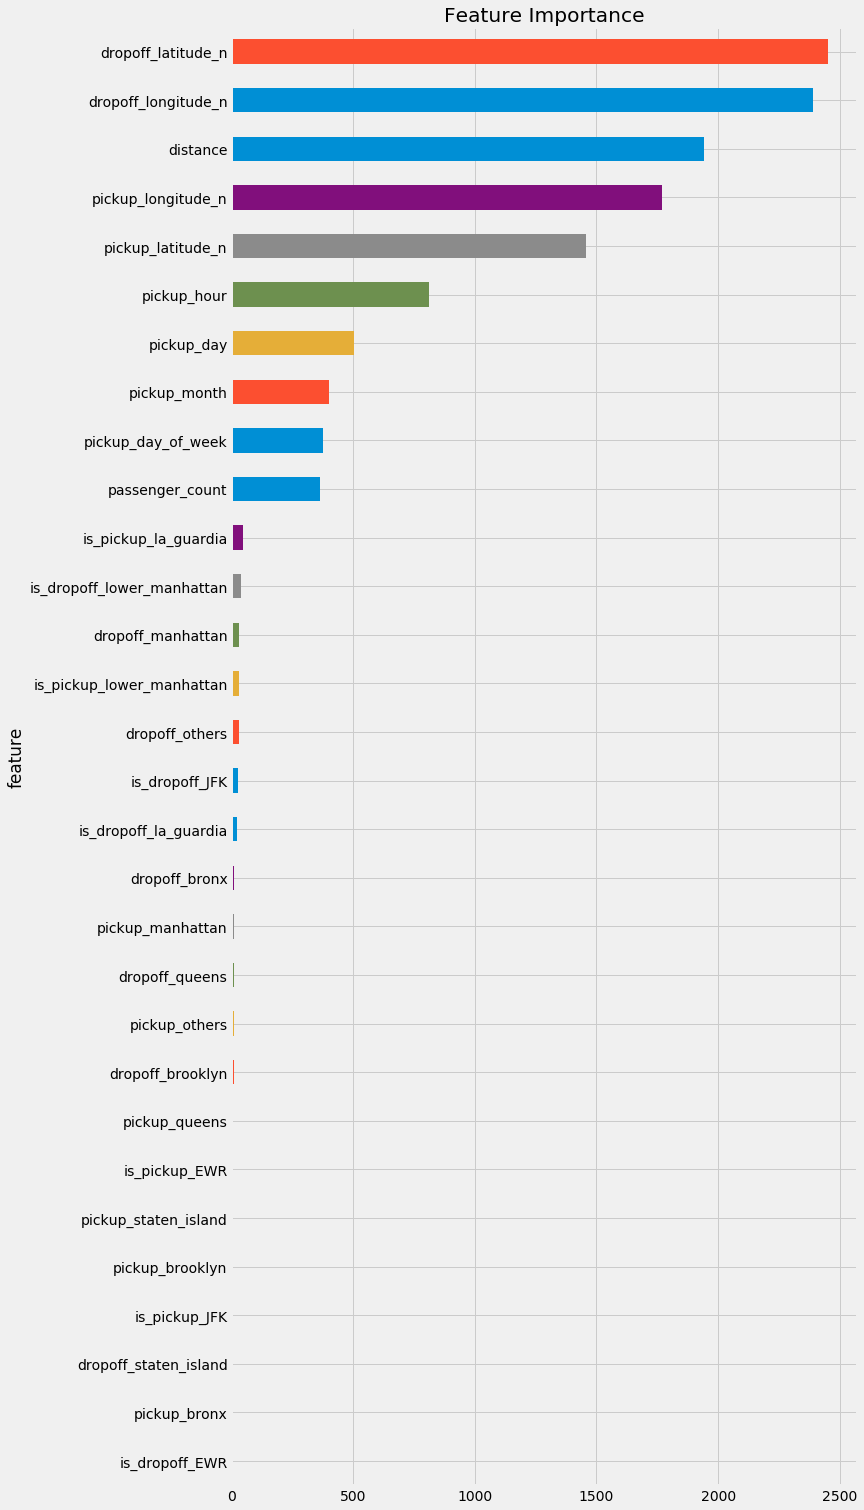

In [125]:
importance=xgbm.get_score()
importance = sorted(importance.items(), key=operator.itemgetter(1))
df_importance = pd.DataFrame(importance, columns=['feature', 'score'])
plt.figure()

df_importance.plot(kind='barh', x='feature', y='score', legend=False, figsize=(10, 25))
plt.title("Feature Importance")

RMSE
Baseline: 4.505
Linear regression with features: 4.178
XGBoost: 3.5768

From the importance graph above, we also observed that is_airport_pickup/dropoff features are not having more importance. But in the exploratory analysis we saw that There is a effect of airport on the price. To take into consideration the same, we can add features like distance from the three airports

In [126]:
def coordinates2distance(lat1,lat2,long1,long2):
    R=6373.0 #radius of earth in km
    p = 0.017453292519943295 # Pi/180 to convert to radians
    lat1=lat1*p
    lat2=lat2*p
    long1=long1*p
    long2=long2*p
    dlon=(long2-long1)
    dlat=(lat2-lat1)
    a=(np.sin(dlat/2)**2)+(np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2)
    c=2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
    return R*c

In [127]:
#del train_1
#del test_1
del X_train,X_test,y_train,y_test
lgr=(-73.8733, 40.7746)
jfk=(-73.7900, 40.6437)
ewr=(-74.1843, 40.6924)

df=data

df['pickup_distance_jfk']=coordinates2distance(df['pickup_latitude_n'].values,
                                    jfk[1],
                                    df['pickup_longitude_n'].values,
                                    jfk[0])

df['dropoff_distance_jfk']=coordinates2distance(df['dropoff_latitude_n'].values,
                                    jfk[1],
                                    df['dropoff_longitude_n'].values,
                                    jfk[0])

df['pickup_distance_ewr']=coordinates2distance(df['pickup_latitude_n'].values,
                                    ewr[1],
                                    df['pickup_longitude_n'].values,
                                    ewr[0])

df['dropoff_distance_ewr']=coordinates2distance(df['dropoff_latitude_n'].values,
                                    ewr[1],
                                    df['dropoff_longitude_n'].values,
                                    ewr[0])
df['pickup_distance_lgr']=coordinates2distance(df['pickup_latitude_n'].values,
                                    ewr[1],
                                    df['pickup_longitude_n'].values,
                                    ewr[0])

df['dropoff_distance_lgr']=coordinates2distance(df['dropoff_latitude_n'].values,
                                    lgr[1],
                                    df['dropoff_longitude_n'].values,
                                    lgr[0])



Number of records in training data  1188833
Number of records in validation data  509501
[14:37:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[0]	test-rmse:11.1474
Will train until test-rmse hasn't improved in 20 rounds.
[14:38:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[1]	test-rmse:8.28657
[14:38:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[2]	test-rmse:6.42006
[14:38:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[3]	test-rmse:5.26153
[14:38:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[4]	te

[46]	test-rmse:3.5255
[14:40:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[47]	test-rmse:3.52113
[14:40:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[48]	test-rmse:3.52053
[14:41:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[49]	test-rmse:3.51912
[14:41:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[50]	test-rmse:3.5183
[14:41:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[51]	test-rmse:3.51719
[14:41:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots

[93]	test-rmse:3.48412
[14:43:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[94]	test-rmse:3.48433
[14:43:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[95]	test-rmse:3.48399
[14:43:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[96]	test-rmse:3.48337
[14:44:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[97]	test-rmse:3.48319
[14:44:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[98]	test-rmse:3.48235
[14:44:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roo

[140]	test-rmse:3.46894
[14:46:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[141]	test-rmse:3.46829
[14:46:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[142]	test-rmse:3.46861
[14:47:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[143]	test-rmse:3.46838
[14:47:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[144]	test-rmse:3.46791
[14:47:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[145]	test-rmse:3.46811
[14:47:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end,

[187]	test-rmse:3.46158
[14:50:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[188]	test-rmse:3.4615
[14:50:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[189]	test-rmse:3.46165
[14:50:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[190]	test-rmse:3.46132
[14:50:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[191]	test-rmse:3.4612
[14:50:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[192]	test-rmse:3.46107
[14:50:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 r

[234]	test-rmse:3.45716
[14:53:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[235]	test-rmse:3.45716
Stopping. Best iteration:
[215]	test-rmse:3.4569



Text(0.5,1,'Feature Importance')

<Figure size 432x288 with 0 Axes>

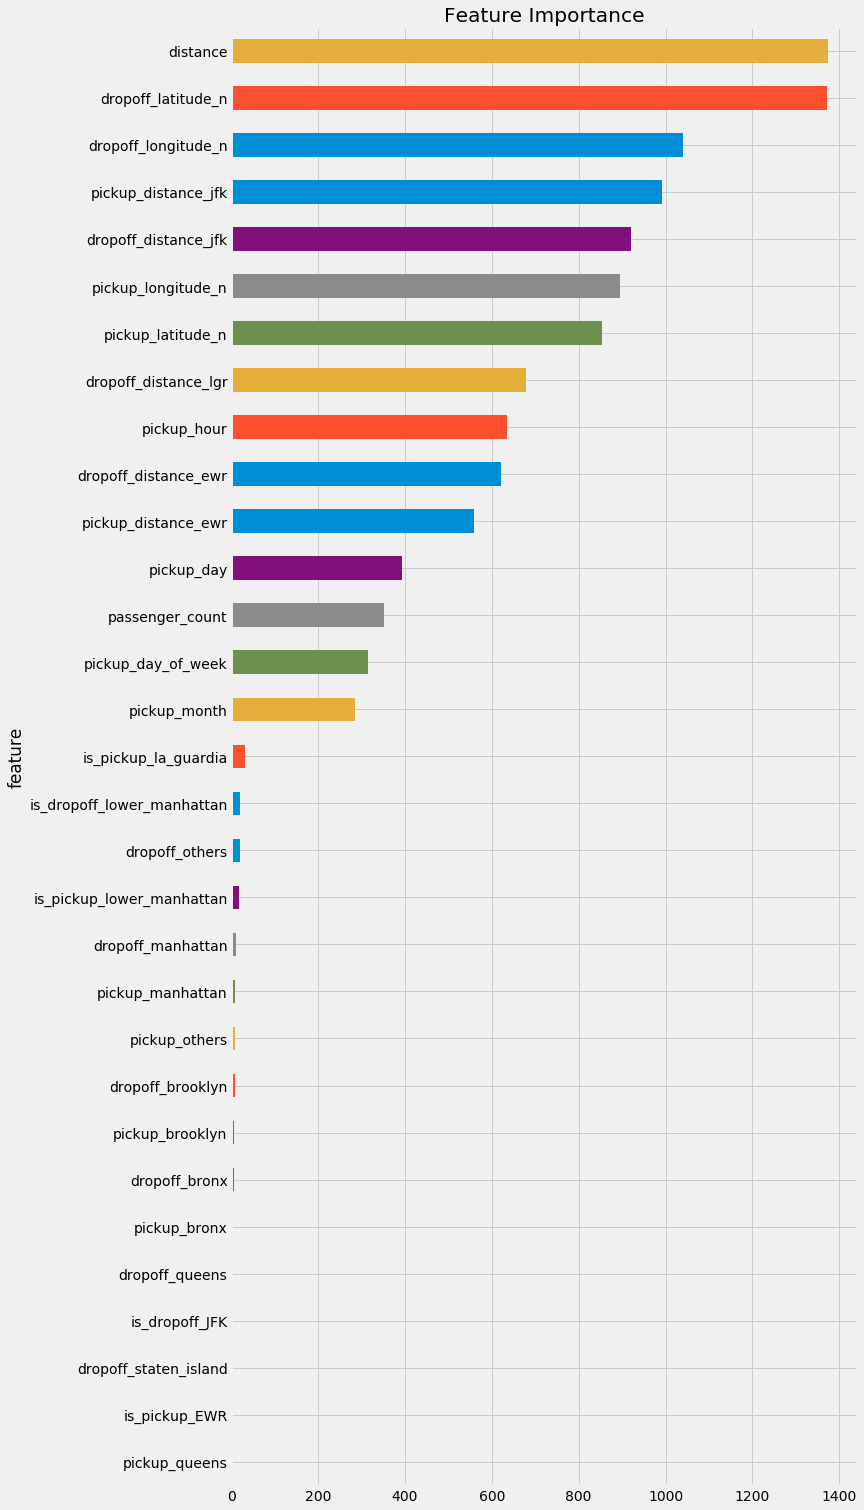

In [128]:
X=df.drop(['fare_amount'],axis=1)
y=df['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
print("Number of records in training data ",X_train.shape[0])
print("Number of records in validation data ",X_test.shape[0])

xgbm = XGBoost(X_train,X_test,y_train,y_test,num_rounds=500)
xgbm_pred = xgbm.predict(xgb.DMatrix(X_test), ntree_limit = xgbm.best_ntree_limit)

#submissions['fare_amount']=xgbm_pred
#submissions.to_csv("XGboost_WithDistancetoAirport.csv",index=False)

importance=xgbm.get_score()
importance = sorted(importance.items(), key=operator.itemgetter(1))
results = pd.DataFrame(importance, columns=['feature', 'score'])
plt.figure()

results.plot(kind='barh', x='feature', y='score', legend=False, figsize=(10, 25))
plt.title("Feature Importance")

#train.to_csv("train_cleaned.csv",index=False)
#test.to_csv("test_cleaned.csv",index=False)

New XGBoost RMSE: 3.4569
Tuning parameters further caused the RMSE to reduce from 3.5768 to 3.4569
can possibly further ad another field: Airport - binary field indicating if an airport is involved in the trip 
Can possibly remove the least important features to make the model a bit simpler 

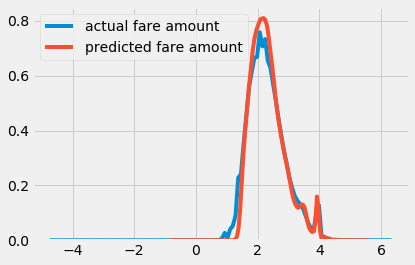

In [133]:
sns.kdeplot(np.log(y_test),label='actual fare amount')
sns.kdeplot(np.log(xgbm_pred),label='predicted fare amount')